# Project question 2 - Which driver upset their teammates the most over their career in Formula One?

## 1. Importing data

In [61]:
import pandas as pd
import numpy as np

results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
qualifying = pd.read_csv('qualifying.csv')
qualifying

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
9810,9868,1110,848,3,23,16,2:00.314,\N,\N
9811,9869,1110,855,51,24,17,2:00.832,\N,\N
9812,9870,1110,858,3,2,18,2:01.535,\N,\N
9813,9871,1110,817,213,3,19,2:02.159,\N,\N


## 2. Preparing data

Preparing training data as well as adding useful features such as a ratio of points to teammate. We once again run into the issue of points systems changing over time, so we will normalize by dividing by total points scored in a race.

In [92]:
def get_results(year1, year2=None):
    if year2 is None:
        races_data = races.loc[races['year'] == year1]
    else:
        races_data = races.loc[(races['year'] >= year1) & (races['year'] <= year2)]

    if races_data.empty:
        return pd.DataFrame()  # Return an empty dataframe if no races are found

    races_year_circuit_data = pd.concat([races_data['raceId'], races_data['circuitId'], races_data['time']], axis=1)
    results_data = results.loc[(results['raceId'].isin(races_data['raceId']))]
    results_data = pd.merge(results_data, races_year_circuit_data, on='raceId')
    results_data = results_data.drop(columns=['time_x', 'positionText', 'resultId', 'fastestLap'])
    results_data = results_data.replace('\\N', 0)
    results_data['time_y'] = results_data['time_y'].apply(find_time)
    results_data['fastestLapTime'] = results_data['fastestLapTime'].apply(find_milliseconds)
    # Convert everything to numeric
    results_data = results_data.apply(pd.to_numeric, errors='coerce')

    # Add a column of total points scored in that race by all drivers
    results_data['total_points_race'] = results_data.groupby('raceId')['points'].transform('sum')

    # Add a year column from races.csv
    results_data = pd.merge(results_data, races[['raceId', 'year']], on='raceId')

    return results_data


def get_driver_results(driverId, year1=1950, year2=2023):
    results_data = get_results(year1, year2)

    driver_results = results_data.loc[results_data['driverId'] == driverId].copy()

    all_teammate_results = pd.DataFrame()

    # Loop over all unique constructorIds in driver_results
    for constructorId in driver_results['constructorId'].unique():
        # Get the results for all drivers from the same constructor
        constructor_results = results_data.loc[results_data['constructorId'] == constructorId].copy()

        # Remove the driver's results from constructor_results
        teammate_results = constructor_results.loc[constructor_results['driverId'] != driverId].copy()

        # Group by 'raceId' and keep only the teammate with the most points in each race
        teammate_results = teammate_results.loc[teammate_results.groupby('raceId')['points'].idxmax()]

        # Rename the columns in teammate_results
        for column in teammate_results.columns:
            if column != 'constructorId' and column != 'raceId':
                teammate_results.rename(columns={column: 'teammate_' + column}, inplace=True)

        all_teammate_results = pd.concat([all_teammate_results, teammate_results])

    # Merge driver_results and all_teammate_results on 'raceId'
    driver_results = pd.merge(driver_results, all_teammate_results, on='raceId', how='left')

    # Calculate the difference in points between the driver and the teammate
    driver_results['points_difference'] = driver_results['points'] - driver_results['teammate_points']

    # Add a column of the difference in points divided by the total points scored in that race
    driver_results['points_difference_ratio'] = driver_results['points_difference'] / driver_results['total_points_race']

    return driver_results

def get_all_driver_results():
    # Get all driver results
    all_driver_results = pd.DataFrame()
    for driverId in drivers['driverId']:
        driver_results = get_driver_results(driverId)
        all_driver_results = pd.concat([all_driver_results, driver_results])
    # Replace all NaN values with 0
    all_driver_results = all_driver_results.fillna(0)
    return all_driver_results

def find_milliseconds(laptime):
    if str(laptime)!='0':
        minutes, seconds_and_ms = str(laptime).split(':')
        seconds, milliseconds = seconds_and_ms.split('.')
        return int(int(minutes) * 60000 + int(seconds) * 1000 + int(milliseconds))
    else:
        return 0

def find_time(time):
    if (time == 0):
        return 0
    hours, minutes, seconds = str(time).split(':')
    return (int(hours) * 100) + int(minutes)

all_results = get_all_driver_results()

## 3. Making the model

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

training_all_results = all_results.drop(columns=['points_difference','points','teammate_points','points_difference_ratio', 'position', 'teammate_position', 'positionOrder', 'teammate_positionOrder'])

X = training_all_results
y = all_results['points_difference_ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the random forest regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)
print("Mean Squared Error:", mse, "R2 Score:", r2)

Mean Squared Error: 0.0026210781996117987 R2 Score: 0.8528251703075713


In [94]:
predictions = model.predict(training_all_results)

all_results['predicted_points_difference_ratio'] = predictions

# Find the highest predict points difference ratio
all_results.sort_values(by=['predicted_points_difference_ratio'], ascending=False).head(10)

,raceId,driverId,constructorId_x,number,grid,position,positionOrder,points,laps,milliseconds,...,teammate_fastestLapTime,teammate_fastestLapSpeed,teammate_statusId,teammate_circuitId,teammate_time_y,teammate_total_points_race,teammate_year,points_difference,points_difference_ratio,predicted_points_difference_ratio
73,722,373,172,18,1,1,1,9.0,53,7854300,...,0.0,0.0,13.0,55.0,0.0,21.0,1963.0,9.0,0.428571,0.394202
81,449,182,1,8,4,1,1,9.0,51,4829065,...,0.0,0.0,5.0,14.0,0.0,22.0,1984.0,9.0,0.409091,0.389391
256,173,30,6,3,1,1,1,10.0,53,5393435,...,0.0,0.0,11.0,22.0,0.0,26.0,2000.0,10.0,0.384615,0.383077
592,452,137,34,5,4,1,1,9.0,63,6507731,...,0.0,0.0,12.0,36.0,0.0,19.0,1983.0,9.0,0.473684,0.381580
248,171,30,6,3,1,1,1,10.0,53,5251638,...,0.0,0.0,4.0,14.0,0.0,26.0,2000.0,10.0,0.384615,0.381292
438,210,49,3,4,2,1,1,10.0,62,5460673,...,0.0,0.0,6.0,21.0,0.0,26.0,1997.0,10.0,0.384615,0.380000
208,157,30,6,1,1,1,1,10.0,53,5253298,...,0.0,0.0,11.0,22.0,0.0,26.0,2001.0,10.0,0.384615,0.378215
184,149,30,6,1,1,1,1,10.0,67,5382724,...,0.0,0.0,20.0,20.0,0.0,26.0,2001.0,10.0,0.384615,0.378215
75,302,95,3,5,1,1,1,10.0,71,5686659,...,0.0,0.0,4.0,27.0,0.0,26.0,1992.0,10.0,0.384615,0.377046
449,215,35,3,3,1,1,1,10.0,59,5281665,...,0.0,0.0,4.0,9.0,0.0,26.0,1997.0,10.0,0.384615,0.376923


The driver who was predicted to dominate their teammate the most at a single race was Jim Clark at the 1963 French Grand Prix, where his teammate failed to finish. 

## Turning race predictions into season predictions (NEW)

array([  1,   4,   8,   9,  20, 842, 815, 817, 822, 830, 832, 839, 840,
       841, 844, 846, 847, 849, 852, 853, 854], dtype=int64)

## Turning race predictions into season predictions (OLD)

In [14]:
# Calculate the total points difference for each driver over the season
season_results = all_results.groupby(['driverId', 'year']).agg({
    'grid': 'sum',
    'laps': 'sum',
    'milliseconds': 'sum',
    'rank': 'sum',
    'fastestLapTime': 'sum',
    'fastestLapSpeed': 'sum',
    'teammate_grid': 'sum',
    'teammate_laps': 'sum',
    'teammate_milliseconds': 'sum',
    'teammate_rank': 'sum',
    'teammate_fastestLapTime': 'sum',
    'teammate_fastestLapSpeed': 'sum'
})
season_results.reset_index(inplace=True)

# Split the data into training and testing sets
X_season = season_results.drop(columns=['points_difference_ratio'])
y_season = season_results['points_difference_ratio']
X_season_train, X_season_test, y_season_train, y_season_test = train_test_split(X_season, y_season, test_size=0.2, random_state=42)

# Create the random forest regressor model for the season
season_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the season model
season_model.fit(X_season_train, y_season_train)

# Make predictions on the test set for the season
y_season_pred = season_model.predict(X_season_test)

# Evaluate the season model
mse_season = mean_squared_error(y_season_test, y_season_pred)
r2_season = season_model.score(X_season_test, y_season_test)
print("Mean Squared Error (Season):", mse_season, "R2 Score (Season):", r2_season)

KeyError: "['points_difference_ratio'] not found in axis"

## Finding the driver with the highest predicted season result

In [33]:
max_index = np.argmax(y_season_pred)
max_driver = X_season_test.iloc[max_index]
print(max_driver)

# Find who this driver is
driver = drivers.loc[drivers['driverId'] == max_driver['driverId']]
print(driver)

# Find their teammate
teammate = drivers.loc[drivers['driverId'] == max_driver['teammate_driverId']]
print(teammate)

driverId                          579.0
year                             1957.0
raceId                          42127.0
constructorId                    5670.0
number                            370.0
grid                              114.0
position                           69.0
positionOrder                     147.0
points                            359.0
laps                             3529.0
milliseconds                524773200.0
rank                                0.0
fastestLapTime                      0.0
fastestLapSpeed                     0.0
statusId                           78.0
circuitId                        1677.0
time_y                              0.0
total_points_race                1296.0
teammate_driverId               27529.0
teammate_number                   886.0
teammate_grid                     551.0
teammate_position                 166.0
teammate_positionOrder            588.0
teammate_points                    32.0
teammate_laps                    2229.0


Juan Manuel Fangio in 1957 is the one who beat his teammate the worst.

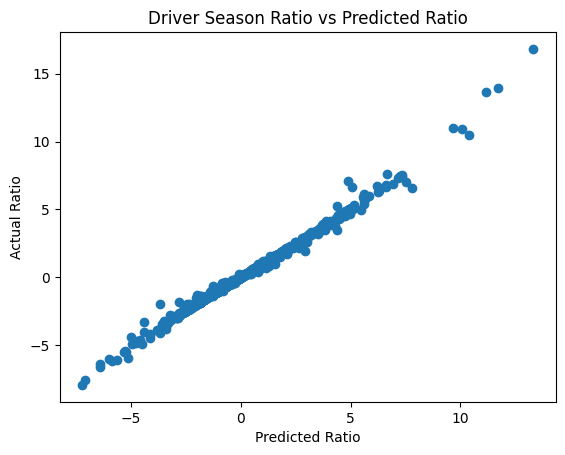

In [34]:
import matplotlib.pyplot as plt

# Get the predicted season ratios
predicted_ratios = season_model.predict(X_season)

# Create the scatter plot
plt.scatter(predicted_ratios, y_season)

# Add labels and title
plt.xlabel('Predicted Ratio')
plt.ylabel('Actual Ratio')
plt.title('Driver Season Ratio vs Predicted Ratio')

# Show the plot
plt.show()


In [35]:
import matplotlib.pyplot as plt

# Get the top 10 highest predicted ratios and corresponding drivers
top_10_predicted = X_season_test.nlargest(10, 'points_difference_ratio')
drivers_top_10 = drivers.loc[drivers['driverId'].isin(top_10_predicted['driverId'])]

# Create the bar graph
plt.bar(drivers_top_10['driverId'], top_10_predicted['points_difference_ratio'])

# Add labels and title
plt.xlabel('Driver ID')
plt.ylabel('Predicted Ratio')
plt.title('Top 10 Drivers with Highest Predicted Ratios')

# Show the plot
plt.show()


KeyError: 'points_difference_ratio'